### IDEAS

* Bad news in the end: our CV scheme is not perfect. Try to improve it! (hint: is all training set needed for a good prediction?
* Посчитать длительность посещения топ сайтов Алисы


### HINTS


* keep track of cross-validation improvements for each fold (or at least as many folds as possible)
* take a look at cross-validation std, not only mean
* try to build a CV scheme so that CV improvements correlate with LB improvements (it's very important)
* exploring feature importance might help, sometimes even in detecting overfitting
* spend most of the competition time exploring data and building features

* existing features, try multiplying or dividing two of them
* do not hesitate to convert an existing feature (for example, take a logarithm), etc.

In [1]:
!python --version

Python 3.7.4


In [2]:
!pip install eli5

  Using cached https://files.pythonhosted.org/packages/97/2f/c85c7d8f8548e460829971785347e14e45fa5c6617da374711dec8cb38cc/eli5-0.10.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/66/d4/977fdd5186b7cdbb7c43a7aac7c5e4e0337a84cb802e154616f3cfc84563/tabulate-0.8.5.tar.gz
  Created wheel for tabulate: filename=tabulate-0.8.5-cp37-none-any.whl size=23261 sha256=6f36347479cd6aa2577cd0ed1b19148cbdca858e88f14299fd23a62ff5fe351f
  Stored in directory: C:\Users\TnavCluster\AppData\Local\pip\Cache\wheels\e1\41\5e\e201f95d90fc84f93aa629b6638adacda680fe63aac47174ab
Successfully built tabulate


In [3]:
# Import libraries and set desired options
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import hstack

# !pip install eli5
import eli5
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display_html

In [4]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin

import warnings
warnings.filterwarnings('ignore')

In [5]:
PATH_TO_DATA = 'data/'
PATH_TO_SUBMISSIONS = 'submits/'
path_to_site_dict = os.path.join(PATH_TO_DATA, 'site_dic.pkl')
SEED = 17

In [6]:
time_split = TimeSeriesSplit(n_splits=10)

In [7]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    subm_path = os.path.join(PATH_TO_SUBMISSIONS, out_file)
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

def train_and_predict(model, X_train, y_train, X_test, all_func=False,
                      new_feature_names=None, cv=time_split, scoring='roc_auc',
                      top_n_features_to_show=30, submission_file_name='submission.csv'):

    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    print('CV scores', cv_scores)
    print('CV mean: {}, CV std: {}'.format(cv_scores.mean(), cv_scores.std()))
    model.fit(X_train, y_train)
    
    if all_func:
        site_feature_names = model.named_steps['feats'].get_params()['tfidf__tfidf'].get_feature_names()
        site_feature_names = [' '.join([id2site[int(site_idx)] for site_idx in fn.split(' ')]) for fn in site_feature_names ]
        if new_feature_names:
            all_feature_names = site_feature_names + new_feature_names 
        else: 
            all_feature_names = site_feature_names

        display_html(eli5.show_weights(estimator=model.named_steps['clf'], 
                      feature_names=all_feature_names, top=top_n_features_to_show))

        if new_feature_names:
            print('New feature weights:')

            print(pd.DataFrame({'feature': new_feature_names, 
                            'coef': model.named_steps['clf'].coef_.flatten()[-len(new_feature_names):]}))
    
        test_pred = model.predict_proba(X_test)[:, 1]
        subm_path = os.path.join(PATH_TO_SUBMISSIONS, submission_file_name)
        write_to_submission_file(test_pred, subm_path) 
    
    return cv_scores

In [8]:
times = [f"time{i}" for i in range(1, 11)]
sites = [f"site{i}" for i in range(1, 11)]

df_train = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='session_id', parse_dates=times)
df_test = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'), index_col='session_id', parse_dates=times)

df_train = df_train.sort_values('time1')

df_train['index'] = np.arange(df_train.shape[0])
df_test['index'] = np.arange(df_train.shape[0], df_train.shape[0] + df_test.shape[0])

In [9]:
with open(path_to_site_dict, 'rb') as f:
    site2id = pickle.load(f)

id2site = {v:k for (k, v) in site2id.items()}
id2site[0] = 'unknown'

In [10]:
df_train.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,site7,time7,site8,time8,site9,time9,site10,time10,target,index
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,1
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0,2
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0,3
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0,4


In [11]:
top_sites = pd.Series(df_train[sites].fillna(0).values.flatten()).value_counts().sort_values(ascending=False).drop(index=[0])

top_sites_alice = pd.Series(df_train[df_train.target==1][sites].fillna(0).values.flatten()).value_counts().sort_values(ascending=False).drop(index=[0])

In [12]:
def preproc_data(X):
    new_data = pd.DataFrame(index=X.index)
    
    # sites params
    print("Making sites in one row")
    for col in sites:
        new_data[col] = X[col].fillna(0).astype(int)
    new_data['sites'] = new_data[sites].apply(lambda row: ' '.join(row[row != 0].astype(str)), axis=1)
    new_data['sites_text'] = new_data[sites].apply(lambda row: ' '.join([id2site[i] for i in row]), axis=1)
    
    print("Count sites")
    new_data['n_sites'] = X[sites].notna().sum(axis=1)
    new_data['n_unique_sites'] = X[sites].nunique(axis=1) - X['site10'].isna().astype(int)
    new_data['rate_unique_sites'] = new_data['n_unique_sites'] / new_data['n_sites']
    
    for n_top in [5, 20, 50, 100]:
        print("Count top", n_top)
        new_data['top5'] = new_data['n_unique_sites'] / new_data['n_sites']
        
        new_data[f'top{n_top}'] = X[sites].isin(top_sites.index[:n_top]).sum(axis=1)
        new_data[f'utop{n_top}'] = X[sites].apply(lambda row: np.isin(pd.unique(row), top_sites.index[:n_top]).sum(), axis=1)
        new_data[f'top_rate{n_top}'] = new_data[f'top{n_top}'] / new_data['n_sites']
    
        new_data[f'atop{n_top}'] = X[sites].isin(top_sites_alice.index[:n_top]).sum(axis=1)
        new_data[f'uatop{n_top}'] = X[sites].apply(lambda row: np.isin(pd.unique(row), top_sites_alice.index[:n_top]).sum(), axis=1)
        new_data[f'top_arate{n_top}'] = new_data[f'atop{n_top}'] / new_data['n_sites']

    # times params
    print("Eval duration")
    new_data['s_duration'] = (X[times].max(axis=1) - X[times].min(axis=1)).astype('timedelta64[s]').astype(int)
    new_data['s_duration_log'] = new_data['s_duration'].apply(np.log1p)
    
    print("Eval time diffs")
    tdiff = X[times].diff(axis=1)
    for col in times:
        tdiff[col] = tdiff[col].dt.total_seconds()
        tdiff.loc[tdiff[col] > 1800, col] = np.NaN
    new_data[[f'tdiff_{col}' for col in times[1:]]] = tdiff[times[1:]]
    new_data['tdiff_mean'] = tdiff[times[1:]].mean(axis=1)
    new_data['tdiff_std'] = tdiff[times[1:]].std(axis=1)
    new_data['tdiff_var'] = tdiff[times[1:]].var(axis=1)
    
    print("Eval hour params")
    new_data['hour'] = X['time1'].dt.hour
    new_data['hour_sin'] = new_data['hour'].apply(lambda ts: np.sin(2*np.pi*ts/24.))
    new_data['hour_cos'] = new_data['hour'].apply(lambda ts: np.cos(2*np.pi*ts/24.))
    new_data['hour_sin_17h'] = new_data['hour'].apply(lambda ts: np.sin(2*np.pi*(ts - 7)/17.))
    new_data['hour_cos_17h'] = new_data['hour'].apply(lambda ts: np.cos(2*np.pi*(ts - 7)/17.))
    
    new_data['hour_bin_1.1'] = new_data['hour'].apply(lambda hour: int(hour >= 0 and hour <= 6))
    new_data['hour_bin_1.2'] = new_data['hour'].apply(lambda hour: int(hour >= 7 and hour <= 11)) 
    new_data['hour_bin_1.3'] = new_data['hour'].apply(lambda hour: int(hour >= 12 and hour <= 18)) 
    new_data['hour_bin_1.4'] = new_data['hour'].apply(lambda hour: int(hour >= 19 and hour <= 23))

    new_data['hour_bin_2.1'] = new_data['hour'].apply(lambda hour: int(hour <= 11)) 
    new_data['hour_bin_2.2'] = new_data['hour'].apply(lambda hour: int(hour >= 12 and hour <= 13)) 
    new_data['hour_bin_2.3'] = new_data['hour'].apply(lambda hour: int(hour >= 14 and hour <= 15)) 
    new_data['hour_bin_2.4'] = new_data['hour'].apply(lambda hour: int(hour >= 16 and hour <= 18)) 
    new_data['hour_bin_2.5'] = new_data['hour'].apply(lambda hour: int(hour >= 19 and hour <= 23))
    
    new_data['hour_bin_3.1'] = new_data['hour'].apply(lambda hour: int(hour <= 11)) 
    new_data['hour_bin_3.2'] = new_data['hour'].apply(lambda hour: int(hour >= 12 and hour <= 15))
    new_data['hour_bin_3.3'] = new_data['hour'].apply(lambda hour: int(hour >= 16 and hour <= 18)) 
    new_data['hour_bin_3.4'] = new_data['hour'].apply(lambda hour: int(hour >= 19 and hour <= 23))
    
    new_data['hour_minutes'] = X['time1'].dt.hour * 60 + X['time1'].dt.minute
    new_data['hour_minutes_sin'] = new_data['hour_minutes'].apply(lambda ts: np.sin(2*np.pi*ts/1440.))
    new_data['hour_minutes_cos'] = new_data['hour_minutes'].apply(lambda ts: np.cos(2*np.pi*ts/1440.))
    
    print("Eval other time params")
    new_data['day'] = X['time1'].dt.day
    new_data['week'] = X['time1'].dt.weekday
    new_data['holiday'] = (new_data['week'] >= 5).astype(int)
    new_data['month'] = X['time1'].dt.month
    new_data['quarter'] = X['time1'].dt.quarter

    return new_data

In [13]:
X_train = preproc_data(df_train)
X_test = preproc_data(df_test)
y_train = df_train['target']

X_train.head()

Making sites in one row
Count sites
Count top 5
Count top 20
Count top 50
Count top 100
Eval duration
Eval time diffs
Eval hour params
Eval other time params


,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,hour_bin_3.3,hour_bin_3.4,hour_minutes,hour_minutes_sin,hour_minutes_cos,day,week,holiday,month,quarter
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0,...,0,0,485,0.854912,-0.518773,12,5,1,1,1
54843,56,55,56,55,0,0,0,0,0,0,...,0,0,517,0.774393,-0.632705,12,5,1,1,1
77292,946,946,951,946,946,945,948,784,949,946,...,0,0,530,0.737277,-0.675590,12,5,1,1,1
114021,945,948,949,948,945,946,947,945,946,946,...,0,0,530,0.737277,-0.675590,12,5,1,1,1
146670,947,950,948,947,950,952,946,951,946,947,...,0,0,530,0.737277,-0.675590,12,5,1,1,1


In [14]:
sites_cols_all = ['n_sites', 'n_unique_sites', 'rate_unique_sites', 
                  'top5', 'utop5', 'top_rate5', 'atop5', 'uatop5', 'top_arate5', 
                  'top20', 'utop20', 'top_rate20', 'atop20', 'uatop20', 'top_arate20', 
                  'top50', 'utop50', 'top_rate50', 'atop50', 'uatop50',  'top_arate50', 
                  'top100', 'utop100', 'top_rate100', 'atop100', 'uatop100', 'top_arate100']

times_cols_all = ['s_duration', 's_duration_log',
                  'tdiff_time2', 'tdiff_time3', 'tdiff_time4', 'tdiff_time5', 'tdiff_time6', 'tdiff_time7', 'tdiff_time8', 'tdiff_time9', 'tdiff_time10', 
                  'tdiff_mean', 'tdiff_std', 'tdiff_var', 
                  'hour', 'hour_sin', 'hour_cos', 'hour_sin_17h', 'hour_cos_17h', 
                  'hour_bin_1.1', 'hour_bin_1.2', 'hour_bin_1.3', 'hour_bin_1.4', 
                  'hour_bin_2.1', 'hour_bin_2.2', 'hour_bin_2.3', 'hour_bin_2.4', 'hour_bin_2.5',
                  'hour_bin_3.1', 'hour_bin_3.2', 'hour_bin_3.3', 'hour_bin_3.4',
                  'hour_minutes', 'hour_minutes_sin', 'hour_minutes_cos', 
                  'day', 'week', 'holiday', 'month', 'quarter']

In [15]:
class Selector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

class Multiplier(BaseEstimator, TransformerMixin):
    def __init__(self, multipliers):
        self.multipliers = multipliers

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for col, mult in self.multipliers.items():
            X[col] = X[col] * mult
        return X

class PartScaler(BaseEstimator, TransformerMixin):
    def __init__(self, cols_to_scale):
        self.cols_to_scale = cols_to_scale
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X[self.cols_to_scale])
        return self

    def transform(self, X):
        X[self.cols_to_scale] = self.scaler.transform(X[self.cols_to_scale])
        return X
    
tfidf_col = 'sites'
sites_cols_use = ['n_sites', 'n_unique_sites', 'rate_unique_sites']
times_cols_use = ['s_duration_log', 'tdiff_mean', 'hour_bin_3.1', 'hour_bin_3.2', 'hour_bin_3.3', 'hour_bin_3.4', 
                  'holiday', 'quarter']
sites_cols_scale = sites_cols_use
times_cols_scale = times_cols_use

new_feature_names = sites_cols_use + times_cols_use

pl_sites_tfidf = Pipeline([
            ('select', Selector(key=tfidf_col)),
            ('tfidf', TfidfVectorizer(ngram_range=(1, 3), max_features=50000, 
                                      smooth_idf=True, binary=True, sublinear_tf=True))
            ])

pl_sites = Pipeline([
            ('select', Selector(key=sites_cols_use)),
            ('scaler', PartScaler(cols_to_scale=sites_cols_scale))
            ])
pl_times = Pipeline([
            ('select', Selector(key=times_cols_use)),
            ('scaler', PartScaler(cols_to_scale=times_cols_scale))
            ])

# pl_mm_sites = Pipeline([
#             ('select', Selector(key=sites_cols_use)),
#             ('scaler', MinMaxScaler())
#             ])
# pl_mm_times = Pipeline([
#             ('select', Selector(key=times_cols_use)),
#             ('scaler', MinMaxScaler())
#             ])

feats_all = FeatureUnion([
                    ('tfidf', pl_sites_tfidf), 
                    ('site', pl_sites),
                    ('time', pl_times),
                    ])

pl_all = Pipeline([
                ('feats', feats_all),
                ('clf', LogisticRegression(C=3.36, random_state=17))
              ])

In [16]:
# new_params = {
#     'feats__site__select__key':,
#     'feats__time__select__key':
# }
# pl_all.set_params(new_params)

SyntaxError: invalid syntax (<ipython-input-16-65fce3f8f76e>, line 2)

In [223]:
cv_scores = train_and_predict(pl_all, X_train, y_train, X_test, new_feature_names=new_feature_names, 
                              cv=time_split, submission_file_name='subm1.csv')

CV scores [0.63069556 0.81052432 0.80932491 0.96650384 0.91013896 0.97732602
 0.91728036 0.95154464 0.97860902 0.97585911]
CV mean: 0.8927806742169867, CV std: 0.10659543941822727


Weight?,Feature
+9.506,www.express.co.uk
+9.419,cid-ed6c3e6a5c6608a4.users.storage.live.com
+7.617,www.tete-en-lair.com
+7.302,www.info-jeunes.net
+7.067,inskin01.wt-eu02.net
+6.193,tru.am
+5.963,vk.com
+5.945,cid-4390f92c7906cc9c.users.storage.live.com
+5.762,www.audienceinsights.net
+5.677,www.melty.fr


New feature weights:
              feature      coef
0             n_sites  0.418412
1      n_unique_sites -0.439911
2   rate_unique_sites  0.281502
3      s_duration_log -0.161264
4          tdiff_mean -0.127971
5        hour_bin_3.1 -0.947009
6        hour_bin_3.2  0.448411
7        hour_bin_3.3  1.087984
8        hour_bin_3.4 -0.709140
9             holiday -0.374594
10            quarter  0.459186


times_cols_use = ['hour_bin_1.2', 'hour_bin_1.3', 'hour_bin_1.4', 
                  's_duration_log', 'week']  
times_cols_scale = times_cols_use  
time_multipliers = {col: 4 for col in ['hour_bin_1.2', 'hour_bin_1.3', 'hour_bin_1.4']}  

CV scores [0.84356453 0.80263008 0.93680874 0.97206808 0.92006707 0.95113146
 0.95939422 0.94596484 0.9654401  0.96336943]  
CV mean: 0.9260438552580255, CV std: 0.0542101245717717  


In [18]:
sites_cols_all = ['n_sites', 'n_unique_sites', 'rate_unique_sites', 
                  'top5', 'utop5', 'top_rate5', 'atop5', 'uatop5', 'top_arate5', 
                  'top20', 'utop20', 'top_rate20', 'atop20', 'uatop20', 'top_arate20', 
                  'top50', 'utop50', 'top_rate50', 'atop50', 'uatop50',  'top_arate50', 
                  'top100', 'utop100', 'top_rate100', 'atop100', 'uatop100', 'top_arate100']

times_cols_all = ['s_duration', 's_duration_log',
                  'tdiff_time2', 'tdiff_time3', 'tdiff_time4', 'tdiff_time5', 'tdiff_time6', 'tdiff_time7', 'tdiff_time8', 'tdiff_time9', 'tdiff_time10', 
                  'tdiff_mean', 'tdiff_std', 'tdiff_var', 
                  'hour', 'hour_sin', 'hour_cos', 'hour_sin_17h', 'hour_cos_17h', 
                  'hour_bin_1.1', 'hour_bin_1.2', 'hour_bin_1.3', 'hour_bin_1.4', 
                  'hour_bin_2.1', 'hour_bin_2.2', 'hour_bin_2.3', 'hour_bin_2.4', 'hour_bin_2.5',
                  'hour_bin_3.1', 'hour_bin_3.2', 'hour_bin_3.3', 'hour_bin_3.4',
                  'hour_minutes', 'hour_minutes_sin', 'hour_minutes_cos', 
                  'day', 'week', 'holiday', 'month', 'quarter']

In [80]:
X_train.loc[y_train==1, 's_duration'].quantile(q=[0.8, 0.85, 0.9, 0.925, 0.95, 0.99])

0.800     48.0
0.850     64.0
0.900    101.0
0.925    132.8
0.950    203.4
0.990    826.6
Name: s_duration, dtype: float64

In [81]:
# X_train['div_top100'] = X_train['atop100'] / (X_train['top100'] + 1)
# X_test['div_top100'] = X_test['atop100'] / (X_test['top100'] + 1)
X_train.loc[y_train==1, 's_duration'].quantile(q=[0.8, 0.85, 0.9, 0.925, 0.95, 0.99])

# for df in [X_train, X_test]:
#     df['dur_bin1'] = df['s_duration'] >= 200
#     df['dur_bin1'] = df['s_duration'] >= 100 & df['s_duration'] < 200
#     df['dur_bin1'] = df['s_duration'] >= 200
#     df['dur_bin1'] = df['s_duration'] >= 200

X_train[['d1', 'd2', 'd3', 'd4']] = pd.get_dummies(pd.cut(X_train['s_duration'], [-1, 50, 100, 200, 1000000]), prefix='dur')
X_test[['d1', 'd2', 'd3', 'd4']] = pd.get_dummies(pd.cut(X_test['s_duration'], [-1, 50, 100, 200, 1000000]), prefix='dur')

In [ ]:
sites_cols_use = ['div_top100']
sites_cols_scale = sites_cols_use
site_multipliers = {}

times_cols_use = ['hour_bin_1.2', 'hour_bin_1.3', 'hour_bin_1.4', 
                  'week', 'd1', 'd2', 'd3', 'd4']
times_cols_scale = times_cols_use
time_multipliers = {col: 4 for col in ['hour_bin_1.2', 'hour_bin_1.3', 'hour_bin_1.4']}

new_feature_names = sites_cols_use + times_cols_use

pl_sites = Pipeline([
            ('select', Selector(key=sites_cols_use)),
            ('scaler', PartScaler(cols_to_scale=sites_cols_scale)),
            ('mult', Multiplier(multipliers=site_multipliers))
            ])
pl_times = Pipeline([
            ('select', Selector(key=times_cols_use)),
            ('scaler', PartScaler(cols_to_scale=times_cols_scale)),
            ('mult', Multiplier(multipliers=time_multipliers)),
            ])

feats_all = FeatureUnion([
                    ('tfidf', pl_sites_tfidf), 
#                     ('site', pl_sites),
                    ('time', pl_times),
                    ])

pl_all = Pipeline([
                ('feats', feats_all),
                ('clf', LogisticRegression(C=3.36, random_state=17))
              ])

new_params = {
#     'feats__site__select__key': sites_cols_use,
#     'feats__site__scaler__cols_to_scale': sites_cols_scale,
#     'feats__site__mult__multipliers': site_multipliers,
    'feats__time__select__key': times_cols_use,
    'feats__time__scaler__cols_to_scale': times_cols_scale,
    'feats__time__mult__multipliers': time_multipliers
}

pl_all.set_params(**new_params)

cv_scores = train_and_predict(pl_all, X_train, y_train, X_test, new_feature_names=new_feature_names, all_func=False,
                              cv=time_split, submission_file_name='subm3.csv')

CV scores [0.84067493 0.80454618 0.93571583 0.97222548 0.91996762 0.95053758
 0.95875077 0.94652395 0.9656438  0.96396595]
CV mean: 0.9258552090584896, CV std: 0.054228916287546454


sites_cols_use = ['uatop100']  
sites_cols_scale = sites_cols_use  
site_multipliers = {}  

times_cols_use = ['hour_bin_1.2', 'hour_bin_1.3', 'hour_bin_1.4', 
                  's_duration_log', 'week']  
times_cols_scale = times_cols_use  
time_multipliers = {col: 4 for col in ['hour_bin_1.2', 'hour_bin_1.3', 'hour_bin_1.4']}  

new_feature_names = sites_cols_use + times_cols_use  

CV scores [0.85111185 0.85533776 0.93853267 0.97014242 0.92554882 0.95701375
 0.95473886 0.94702755 0.96315297 0.96172143]  
CV mean: 0.9324328076957368, CV std: 0.04144839862827941  

## EDA

In [23]:
X_train.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,hour_bin_3.3,hour_bin_3.4,hour_minutes,hour_minutes_sin,hour_minutes_cos,day,week,holiday,month,quarter
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0,...,0,0,485,0.854912,-0.518773,12,5,1,1,1
54843,56,55,56,55,0,0,0,0,0,0,...,0,0,517,0.774393,-0.632705,12,5,1,1,1
77292,946,946,951,946,946,945,948,784,949,946,...,0,0,530,0.737277,-0.675590,12,5,1,1,1
114021,945,948,949,948,945,946,947,945,946,946,...,0,0,530,0.737277,-0.675590,12,5,1,1,1
146670,947,950,948,947,950,952,946,951,946,947,...,0,0,530,0.737277,-0.675590,12,5,1,1,1


In [24]:
X_train.columns

Index(['site1', 'site2', 'site3', 'site4', 'site5', 'site6', 'site7', 'site8',
       'site9', 'site10', 'sites', 'sites_text', 'n_sites', 'n_unique_sites',
       'rate_unique_sites', 'top5', 'utop5', 'top_rate5', 'atop5', 'uatop5',
       'top_arate5', 'top20', 'utop20', 'top_rate20', 'atop20', 'uatop20',
       'top_arate20', 'top50', 'utop50', 'top_rate50', 'atop50', 'uatop50',
       'top_arate50', 'top100', 'utop100', 'top_rate100', 'atop100',
       'uatop100', 'top_arate100', 's_duration', 's_duration_log',
       'tdiff_time2', 'tdiff_time3', 'tdiff_time4', 'tdiff_time5',
       'tdiff_time6', 'tdiff_time7', 'tdiff_time8', 'tdiff_time9',
       'tdiff_time10', 'tdiff_mean', 'tdiff_std', 'tdiff_var', 'hour',
       'hour_sin', 'hour_cos', 'hour_sin_17h', 'hour_cos_17h', 'hour_bin_1.1',
       'hour_bin_1.2', 'hour_bin_1.3', 'hour_bin_1.4', 'hour_bin_2.1',
       'hour_bin_2.2', 'hour_bin_2.3', 'hour_bin_2.4', 'hour_bin_2.5',
       'hour_bin_3.1', 'hour_bin_3.2', 'hour_bin_3.3'

In [25]:
top_sites_alice.index[:5]

Float64Index([77.0, 80.0, 76.0, 29.0, 21.0], dtype='float64')

In [35]:
X_train.loc[mask & (y_train==0), 'tdiff_time2'].isna().sum()

200

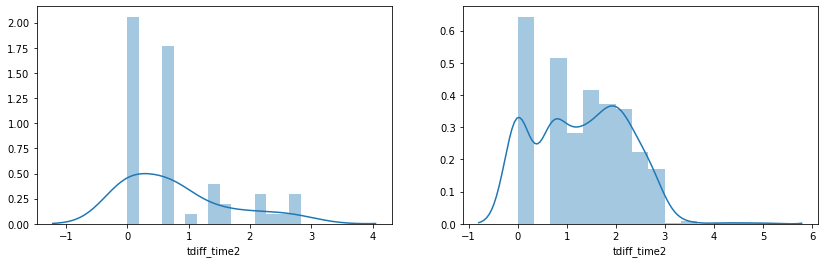

In [47]:
mask = X_train['site1'].isin(top_sites_alice.index[5:6])

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sns.distplot(X_train.loc[mask & (y_train==1), 'tdiff_time2'].apply(np.log1p), ax=axes[0], bins=15)
sns.distplot(X_train.loc[mask & (y_train==0), 'tdiff_time2'].fillna(0).apply(np.log1p), ax=axes[1], bins=15);

In [72]:
id2site

{25075: 'www.abmecatronique.com',
 13997: 'groups.live.com',
 42436: 'majeureliguefootball.wordpress.com',
 30911: 'cdt46.media.tourinsoft.eu',
 8104: 'www.hdwallpapers.eu',
 37491: 'img378.imageshack.us',
 5462: 'ecologie.nature.free.fr',
 35425: 'www.ibcn.intec.ugent.be',
 30151: 'kissanime.com',
 38268: 'www.carolineconduiteformation.com',
 43641: 'images.mystockphoto.com',
 36959: 'journalph.csphares.qc.ca',
 40935: 'www.uqo.ca',
 12346: 'd8d94e0wul1nb.cloudfront.net',
 31023: 'openapi.elong.com',
 31114: 'flamenco-o.blogspot.com',
 28165: 'www.pages-annuaire.net',
 31877: 'smart2000.pagesperso-orange.fr',
 31070: 'fast.forbes.com',
 12938: 'i1-js-14-3-01-10077-536503633-i.init.cedexis-radar.net',
 42002: 'i1-js-14-3-01-11074-716595896-i.init.cedexis-radar.net',
 5671: 'www.pacajob.com',
 32074: 'mathaa.epfl.ch',
 7104: 'cbv.sfr.bench.cedexis.com',
 1939: 'fbcdn-sphotos-b-a.akamaihd.net',
 6708: 'www.mystere-tv.com',
 43589: 'www.mon-ip.fr',
 45241: 'www.aqua-passion.com',
 16195: 

In [73]:
top_sites_alice.iloc[:30].index.map(id2site)

Index(['i1.ytimg.com', 's.youtube.com', 'www.youtube.com', 'www.facebook.com',
       'www.google.fr', 'r4---sn-gxo5uxg-jqbe.googlevideo.com',
       'r1---sn-gxo5uxg-jqbe.googlevideo.com', 'apis.google.com',
       's.ytimg.com', 'r2---sn-gxo5uxg-jqbe.googlevideo.com', 'www.google.com',
       's-static.ak.facebook.com', 'r3---sn-gxo5uxg-jqbe.googlevideo.com',
       'twitter.com', 'static.ak.facebook.com', 'vk.com',
       'translate.google.fr', 'platform.twitter.com', 'yt3.ggpht.com',
       'mts0.google.com', 'www.info-jeunes.net', 'clients1.google.com',
       'www.audienceinsights.net', 'www.melty.fr', 'gg.google.com',
       'plus.googleapis.com', 'mts1.google.com', 'api.bing.com',
       'www.dailymotion.com', 'youwatch.org'],
      dtype='object')